In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  /home/denys_herasymuk/UCU/4course_2term/Bachelor_Thesis/Code/fairness-variance


## Import dependencies

In [4]:
import pandas as pd
import seaborn as sns
import altair as alt
import matplotlib.pyplot as plt
from IPython.display import display

from configs.models_config_for_tuning import MODELS_CONFIG
from source.custom_initializers import create_config_obj, create_models_config_from_tuned_params_df
from source.custom_classes.metrics_composer import MetricsComposer
from source.custom_classes.metrics_visualizer import MetricsVisualizer

sns.set_theme(style="whitegrid")

## Create average metrics files

In [11]:
config = create_config_obj(config_yaml_path=os.path.join('configs', 'experiment1_compas_config.yaml'))

TUNED_PARAMS_FILE_PATH = os.path.join('results', 'models_tuning', f'tuning_results_{config.dataset_name}_20230117__012024.csv')
models_tuned_params_df = pd.read_csv(TUNED_PARAMS_FILE_PATH)

experiment_models_config = create_models_config_from_tuned_params_df(
    models_config_for_tuning=MODELS_CONFIG,
    models_tuned_params_df=models_tuned_params_df,
)

In [14]:
METRICS_PATH = os.path.join('results', 'hypothesis_space', 'COMPAS_Without_Sensitive_Attributes_Metrics_20230123__211059')
# METRICS_PATH = os.path.join('results', 'hypothesis_space', 'COMPAS_Without_Sensitive_Attributes_Metrics_20230122__202033')
# MODELS_NAMES = [model_config['model_name'] for model_config in config.MODELS_CONFIG if 'MLPClassifier' not in model_config['model_name']]
MODELS_NAMES = list(experiment_models_config.keys())
MODELS_NAMES

['DecisionTreeClassifier', 'LogisticRegression']

In [15]:
visualizer = MetricsVisualizer(METRICS_PATH, config.dataset_name, MODELS_NAMES, config.sensitive_attributes_dct)

In [16]:
visualizer.models_average_metrics_dct[MODELS_NAMES[0]].head(20)

,Metric,Model_Name,overall,sex_priv,sex_dis,race_priv,race_dis,sex&race_priv,sex&race_dis
0,Accuracy,DecisionTreeClassifier,0.672348,0.684196,0.669586,0.663900,0.677869,0.668757,0.673864
1,Entropy,DecisionTreeClassifier,0.000000,0.208284,0.000000,0.000000,0.113565,0.104345,0.112007
2,F1,DecisionTreeClassifier,0.633363,0.568503,0.644909,0.493766,0.691540,0.450000,0.700821
3,FNR,DecisionTreeClassifier,0.378074,0.431169,0.368868,0.551470,0.297256,0.574375,0.289753
4,FPR,DecisionTreeClassifier,0.285031,0.250425,0.294750,0.211476,0.347837,0.219048,0.367966
5,General_Ensemble_Accuracy,DecisionTreeClassifier,0.672348,0.684196,0.669586,0.663900,0.677869,0.668757,0.673864
6,IQR,DecisionTreeClassifier,0.087497,0.091650,0.086525,0.088280,0.087053,0.101028,0.087633
7,Jitter,DecisionTreeClassifier,0.117373,0.129470,0.114556,0.104747,0.125788,0.125993,0.124401
8,Label_Stability,DecisionTreeClassifier,0.845047,0.828876,0.848814,0.859592,0.835324,0.833161,0.837457
9,Mean,DecisionTreeClassifier,0.524828,0.560189,0.516592,0.590504,0.481804,0.597691,0.471325


## Visualize average metrics

In [17]:
# Example of MetricsComposer usage
metrics_composer = MetricsComposer(config.sensitive_attributes_dct,
                                   visualizer.models_average_metrics_dct['DecisionTreeClassifier'])
metrics_composer.compose_metrics()

,Metric,sex,race,sex&race
0,Equalized_Odds_TPR,0.062301,0.254214,0.284622
1,Equalized_Odds_FPR,0.044324,0.136361,0.148919
2,Disparate_Impact,0.959556,1.264911,1.143735
3,Statistical_Parity_Difference,-0.040339,0.216135,0.129002
4,Accuracy_Parity,-0.014610,0.013969,0.005108
5,Label_Stability_Ratio,1.024054,0.971768,1.005156
6,IQR_Parity,-0.005125,-0.001227,-0.013394
7,Std_Parity,-0.007089,0.002602,-0.011531
8,Std_Ratio,0.909350,1.036696,0.864649
9,Jitter_Parity,-0.014914,0.021041,-0.001592


### Overall metrics visualizations

In [18]:
def overall_metric_comparison(prediction_metric_name, dataset_name, models_average_results_dct):
    comparison_df = pd.DataFrame(columns=('Dataset_Name', 'Metric_Name', 'Model_Name', 'Metric_Value'))
    for idx, model_name in enumerate(models_average_results_dct.keys()):
        model_average_results_df = models_average_results_dct[model_name]
        comparison_df.loc[idx] = [dataset_name, prediction_metric_name, model_name, model_average_results_df['overall'].loc[prediction_metric_name]]

    return comparison_df.sort_values(by=['Metric_Value'], ascending=False, axis=0)


def display_all_overall_metrics(dataset_name, model_names, models_average_results_dct):
    overall_metrics = list(models_average_results_dct[list(models_average_results_dct.keys())[0]].index)

    for overall_metric in overall_metrics:
        comparison_df = overall_metric_comparison(overall_metric, dataset_name, models_average_results_dct)
        print('#' * 30, f' {overall_metric} Comparison ', '#' * 30)
        display(comparison_df)

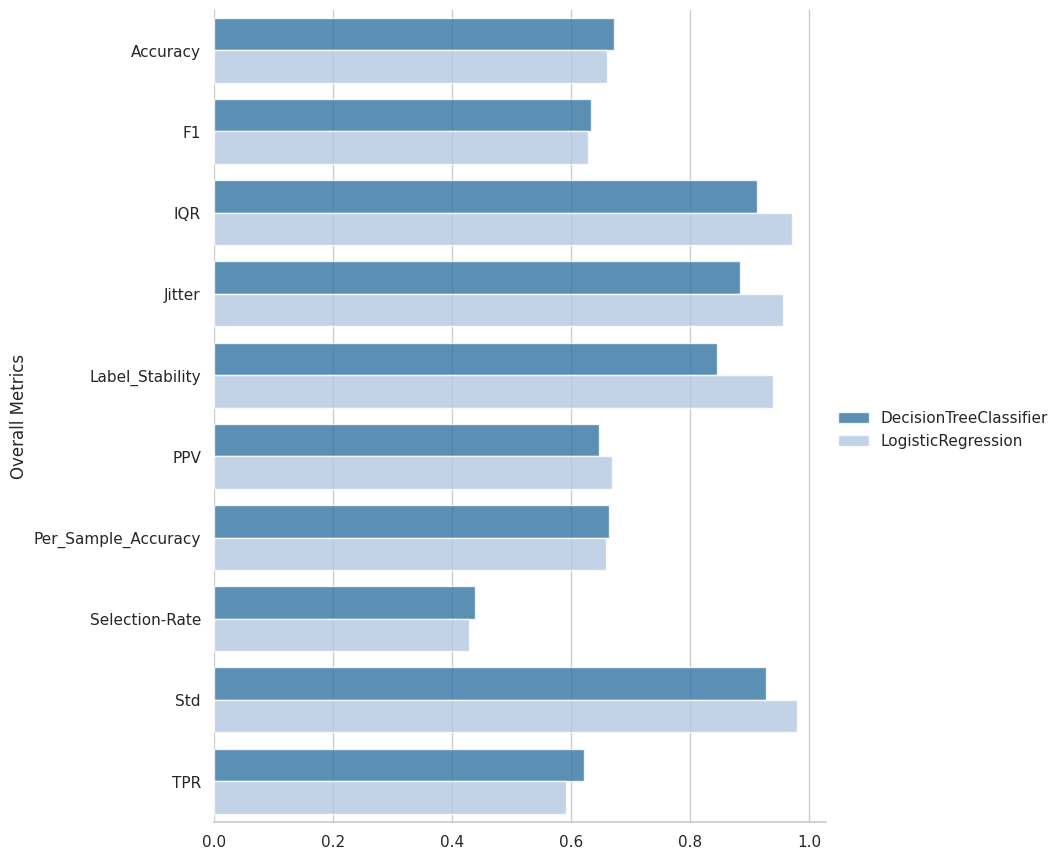

In [19]:
visualizer.visualize_overall_metrics(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate',
                   'Per_Sample_Accuracy', 'Label_Stability'],
    reversed_metrics_names=['Std', 'IQR', 'Jitter'],
    x_label="Overall Metrics"
)

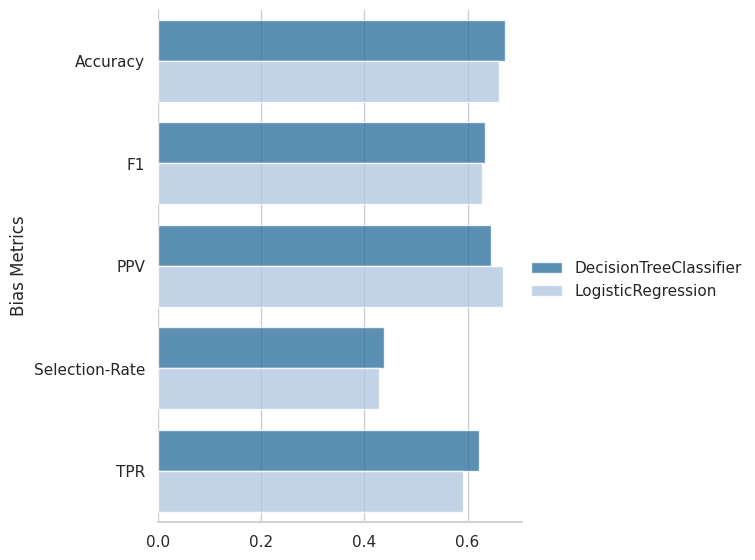

In [20]:
visualizer.visualize_overall_metrics(
    metrics_names=['TPR', 'PPV', 'Accuracy', 'F1', 'Selection-Rate'],
    x_label="Bias Metrics"
)

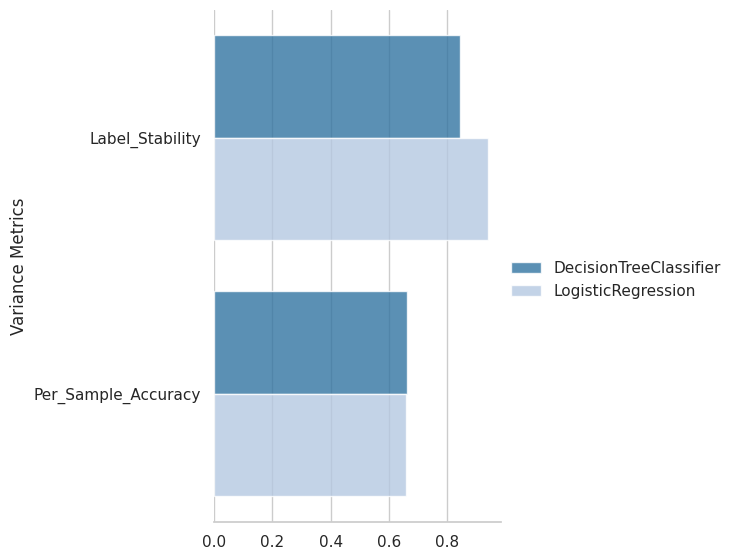

In [21]:
visualizer.visualize_overall_metrics(
    metrics_names=['Per_Sample_Accuracy', 'Label_Stability'],
    x_label="Variance Metrics"
)

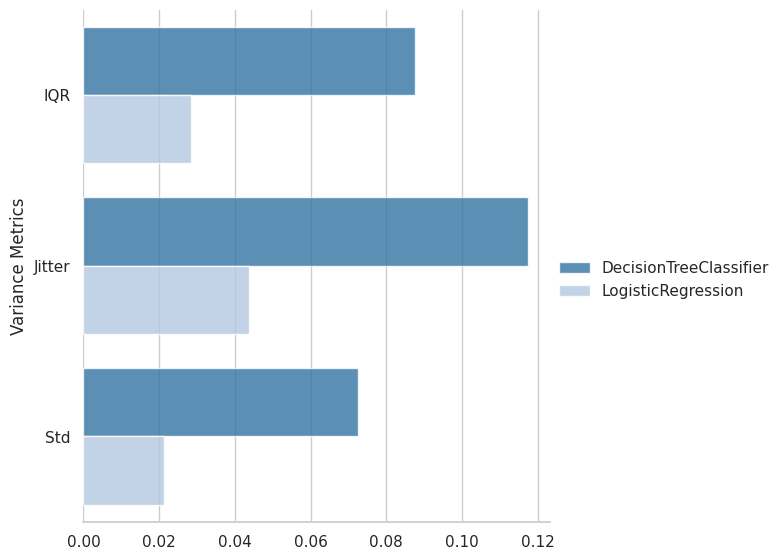

In [22]:
visualizer.visualize_overall_metrics(
    metrics_names=['Std', 'IQR', 'Jitter'],
    x_label="Variance Metrics"
)

In [23]:
visualizer.models_composed_metrics_df.head(20)

,Metric,sex,race,sex&race,Model_Name
0,Equalized_Odds_TPR,0.062301,0.254214,0.284622,DecisionTreeClassifier
1,Equalized_Odds_FPR,0.044324,0.136361,0.148919,DecisionTreeClassifier
2,Disparate_Impact,0.959556,1.264911,1.143735,DecisionTreeClassifier
3,Statistical_Parity_Difference,-0.040339,0.216135,0.129002,DecisionTreeClassifier
4,Accuracy_Parity,-0.014610,0.013969,0.005108,DecisionTreeClassifier
5,Label_Stability_Ratio,1.024054,0.971768,1.005156,DecisionTreeClassifier
6,IQR_Parity,-0.005125,-0.001227,-0.013394,DecisionTreeClassifier
7,Std_Parity,-0.007089,0.002602,-0.011531,DecisionTreeClassifier
8,Std_Ratio,0.909350,1.036696,0.864649,DecisionTreeClassifier
9,Jitter_Parity,-0.014914,0.021041,-0.001592,DecisionTreeClassifier


In [24]:
bias_metrics_lst = [
    'Accuracy_Parity',
    'Equalized_Odds_TPR',
    'Equalized_Odds_FPR',
    'Disparate_Impact',
    'Statistical_Parity_Difference',
]
models_bias_metrics_chart, select_bias_metric_legend, bias_color_legend = \
                visualizer.create_models_metrics_bar_chart(bias_metrics_lst, metrics_group_name="Bias")

In [25]:
variance_metrics_lst = [
    'IQR_Parity',
    'Label_Stability_Ratio',
    'Std_Parity',
    'Std_Ratio',
    'Jitter_Parity',
]
models_variance_metrics_chart, select_variance_metric_legend, variance_color_legend = \
                visualizer.create_models_metrics_bar_chart(variance_metrics_lst, metrics_group_name="Variance")

In [26]:
(
    alt.hconcat(
        alt.vconcat(
            select_bias_metric_legend.properties(height=200, width=50),
            select_variance_metric_legend.properties(height=200, width=50),
            bias_color_legend.properties(height=200, width=50),
        ),
        models_bias_metrics_chart.properties(height=200, width=300, title="Bias Metric Plot"),
        models_variance_metrics_chart.properties(height=200, width=300, title="Variance Metric Plot"),
    )
)

alt.HConcatChart(...)

In [27]:
models_average_results_df = visualizer.all_models_metrics_df

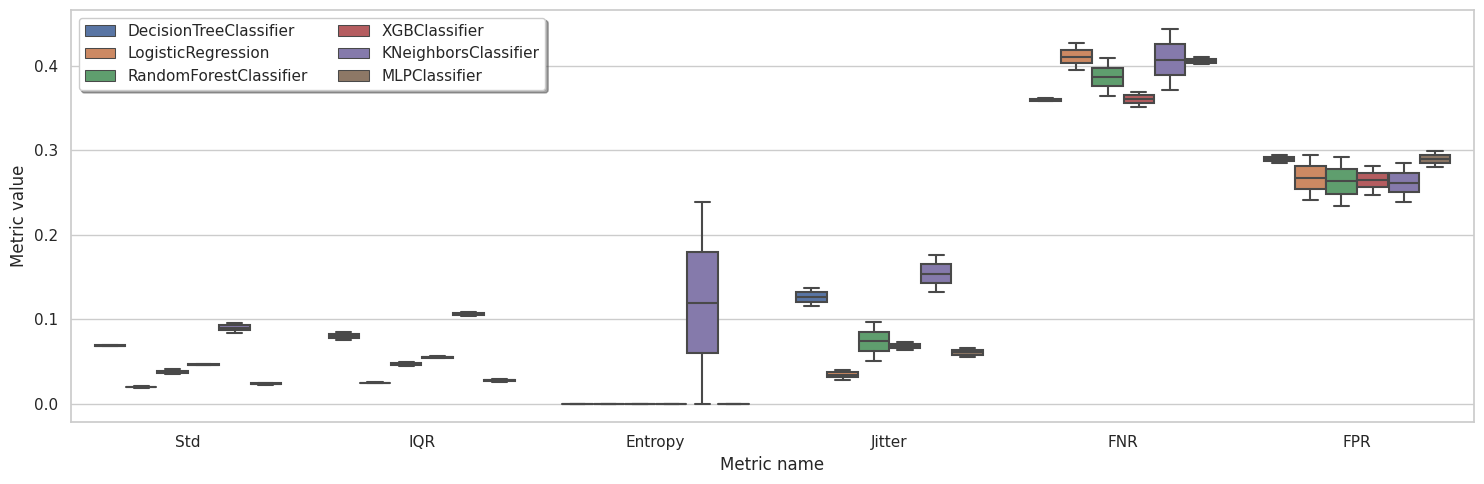

In [79]:
to_plot = models_average_results_df[models_average_results_df['Metric'].isin(['Std', 'IQR', 'Entropy', 'Jitter', 'FNR','FPR'])]

plt.figure(figsize=(15, 5))


sns.boxplot(x = to_plot['Metric'],
            y = to_plot['overall'],
            hue= to_plot['Model_Name'],
            #order=['Accuracy']
            #order=['Accuracy','TNR','TPR','FNR','FPR','Selection-Rate']
           )

plt.legend(loc='upper left',
          ncol=2, fancybox=True, shadow=True)
plt.xlabel("Metric name")
plt.ylabel("Metric value")
#plt.ylim(0,1)
#plt.title("Peformance on overall test set: "+experiment)

plt.tight_layout()

#plt.savefig(filename+'_overall.png', bbox_inches='tight')

In [28]:
sorted_models_composed_metrics_df = visualizer.melted_models_composed_metrics_df.sort_values(by=['Value'])

In [29]:
set(sorted_models_composed_metrics_df.Metric)

{'Accuracy_Parity',
 'Disparate_Impact',
 'Equalized_Odds_FPR',
 'Equalized_Odds_TPR',
 'IQR_Parity',
 'Jitter_Parity',
 'Label_Stability_Ratio',
 'Statistical_Parity_Difference',
 'Std_Parity',
 'Std_Ratio'}

In [30]:
def color_df(val):
    if val is 'RandomForestClassifier':
        color = 'pink' 
    if val is 'LogisticRegression':
        color = 'yellow'
    if val is 'DecisionTreeClassifier':
        color = 'cyan'
    if val is 'XGBClassifier':
        color = 'green'
    if val is 'KNeighborsClassifier':
        color = 'orange'
    if val is 'MLPClassifier':
        color = 'purple'
    return 'background-color: %s' % color

In [32]:
results = {}

for metric in ['Disparate_Impact','Label_Stability_Ratio']:
    for subgroup in config.sensitive_attributes_dct.keys():
        key_name = metric + '_' + subgroup
        results[key_name] = sorted_models_composed_metrics_df[(sorted_models_composed_metrics_df.Metric == metric) & (sorted_models_composed_metrics_df.Subgroup == subgroup)]['Model_Name'].values
        
#pd.DataFrame(results).T
pd.DataFrame(results).T.style.applymap(color_df)

,0,1
Disparate_Impact_sex,DecisionTreeClassifier,LogisticRegression
Disparate_Impact_race,DecisionTreeClassifier,LogisticRegression
Disparate_Impact_sex&race,DecisionTreeClassifier,LogisticRegression
Label_Stability_Ratio_sex,LogisticRegression,DecisionTreeClassifier
Label_Stability_Ratio_race,DecisionTreeClassifier,LogisticRegression
Label_Stability_Ratio_sex&race,LogisticRegression,DecisionTreeClassifier


In [33]:
results = {}

for metric in ['Accuracy_Parity','Equalized_Odds_FPR','Statistical_Parity_Difference','IQR_Parity','Jitter_Parity','Std_Parity']:
    for subgroup in config.sensitive_attributes_dct.keys():
        key_name = metric + '_' + subgroup
        results[key_name] = sorted_models_composed_metrics_df[(sorted_models_composed_metrics_df.Metric == metric) & (sorted_models_composed_metrics_df.Subgroup == subgroup)]['Model_Name'].values

        
pd.DataFrame(results).T.style.applymap(color_df)

,0,1
Accuracy_Parity_sex,DecisionTreeClassifier,LogisticRegression
Accuracy_Parity_race,DecisionTreeClassifier,LogisticRegression
Accuracy_Parity_sex&race,DecisionTreeClassifier,LogisticRegression
Equalized_Odds_FPR_sex,DecisionTreeClassifier,LogisticRegression
Equalized_Odds_FPR_race,DecisionTreeClassifier,LogisticRegression
Equalized_Odds_FPR_sex&race,DecisionTreeClassifier,LogisticRegression
Statistical_Parity_Difference_sex,DecisionTreeClassifier,LogisticRegression
Statistical_Parity_Difference_race,DecisionTreeClassifier,LogisticRegression
Statistical_Parity_Difference_sex&race,DecisionTreeClassifier,LogisticRegression
IQR_Parity_sex,DecisionTreeClassifier,LogisticRegression
